In [14]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from preprocess_koi import KOI
from m_dwarf_selection import M_dwarfs
from KOI_pipeline import KOIPipeline

In [3]:
path = '/Volumes/G-DRIVE/ASTRGR6012/KOI_catalog.csv'

In [4]:
KOI_data = KOIPipeline.run_data(path)

[KOI] Loading KOI catalog from: /Volumes/G-DRIVE/ASTRGR6012/KOI_catalog.csv
[KOI] Loaded 9564 rows and 52 columns.
*********************************
After dropping unused cols: (9564, 49)
After dropping FALSE POSITIVES: (4725, 49)
Final preprocessed shape: (4725, 50)
*********************************
M-dwarf selection applied: 172 rows kept out of 4725


In [5]:
m_dwarfs = KOI_data["m_dwarfs"]
#m_dwarfs.columns

In [6]:
X, y, feature_names = KOIPipeline.model_features(m_dwarfs)

[build] Feature matrix shape: (172, 47)
[build] Label vector shape:   (172,)
[build] Num features: 47


In [7]:
pipeline = KOIPipeline()
pipeline.split_data(X, y);

[split] Train: 137
[split] Val:   17
[split] Test:  18
[balance] Train: {0: 100, 1: 37}
[balance] Val:   {0: 13, 1: 4}
[balance] Test:  {0: 13, 1: 5}


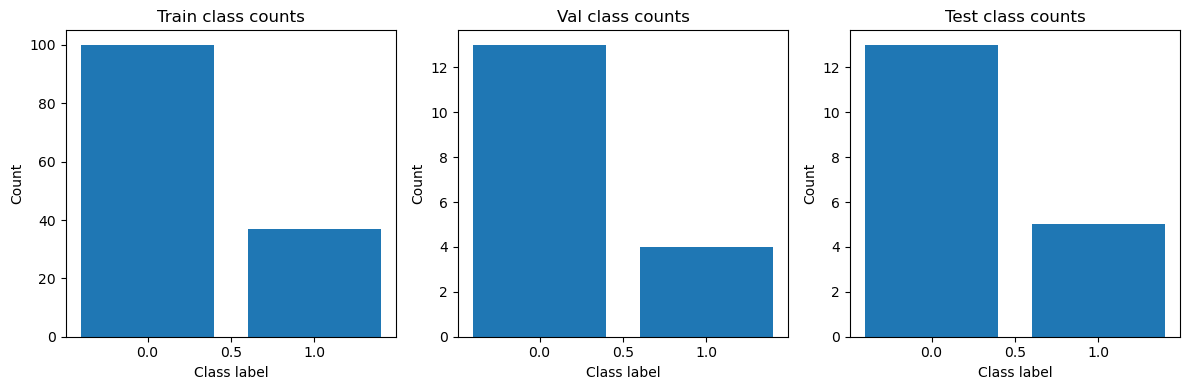

In [8]:
KOIPipeline.plot_class_counts(pipeline.y_train, pipeline.y_val, pipeline.y_test)

#### Retrieving Light Curves from Kepler

These are not raw light curve. They are processed Kepler light curve. Decault cadence is a 30 minutes observations.

**Note:** They are stored on the Mikulski Archive for Space Telescopes (MAST).

In [9]:
from KOI_lightcurves import LightKurve_Fetcher, build_folded_lightcurve_dataset

In [10]:
out_dir = '/Volumes/G-DRIVE/ASTRGR6012/Kepler_LightCurves/kepler_mdwarfs_npz'

“Stitched” light curves means joining together all available observing segments of a star into one continuous light curve. Kepler did not observe stars continuously. Instead, it observed in quarters (Q1, Q2, Q3, …), and Lightkurve treats each quarter as a separate light curve file.

**Purpose:** fetch Kepler light curves and cache them as ```.npz.```

In [12]:
LightKurve_Fetcher.download_kepler_lightcurves(
    m_dwarfs,
    out_dir=out_dir,
    overwrite=False,
    max_targets=None,   # None → all targets (e.g. 172)
)

[download] KIC 11923270…
  -> using PDCSAP_FLUX (download_all + stitch)
  -> saved /Volumes/G-DRIVE/ASTRGR6012/Kepler_LightCurves/kepler_mdwarfs_npz/KIC11923270.npz (N=64797, keys=['time', 'flux_raw', 'mission', 'cadence', 'flux_flat'])
[download] KIC 4725681…
  -> using PDCSAP_FLUX (download_all + stitch)
  -> saved /Volumes/G-DRIVE/ASTRGR6012/Kepler_LightCurves/kepler_mdwarfs_npz/KIC4725681.npz (N=50173, keys=['time', 'flux_raw', 'mission', 'cadence', 'flux_flat'])
[download] KIC 4913852…
  -> using PDCSAP_FLUX (download_all + stitch)
  -> saved /Volumes/G-DRIVE/ASTRGR6012/Kepler_LightCurves/kepler_mdwarfs_npz/KIC4913852.npz (N=64794, keys=['time', 'flux_raw', 'mission', 'cadence', 'flux_flat'])
[download] KIC 6435936…
  -> using PDCSAP_FLUX (download_all + stitch)
  -> saved /Volumes/G-DRIVE/ASTRGR6012/Kepler_LightCurves/kepler_mdwarfs_npz/KIC6435936.npz (N=64797, keys=['time', 'flux_raw', 'mission', 'cadence', 'flux_flat'])
[download] KIC 7135852…
  -> using PDCSAP_FLUX (download_a

**Building the ML dataset**

**Purpose:** convert raw light curves → fixed-length, phase-folded inputs for a CNN.

In [24]:
X, y, kepids = build_folded_lightcurve_dataset(
    m_dwarfs,
    npz_dir=out_dir,
    N_samples=2048,
    use_flux="flux_flat",   # or "flux_raw"
    label_col="disposition_label",
)

print("X shape:", X.shape)   # (N_objects, 2048)
print("y shape:", y.shape)
print("y counts:", np.bincount(y))
print("First 5 labels:", y[:5])
print("Number of stars loaded:", len(kepids))


X shape: (115, 2048, 1)
y shape: (115,)
y counts: [78 37]
First 5 labels: [0 0 1 1 1]
Number of stars loaded: 115


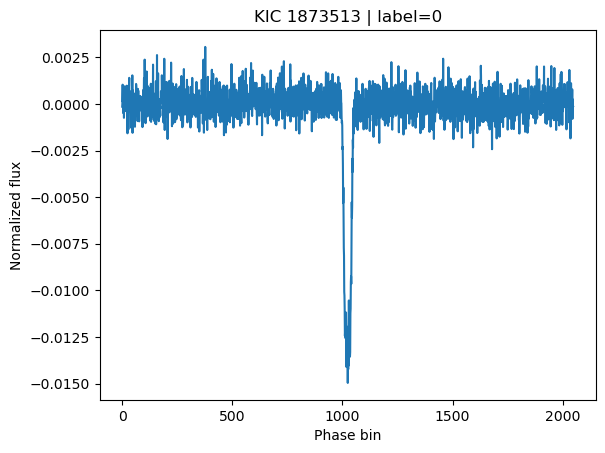

In [15]:
i = 0  # any index
plt.plot(X[i, :, 0])
plt.title(f"KIC {kepids[i]} | label={y[i]}")
plt.xlabel("Phase bin")
plt.ylabel("Normalized flux")
plt.show()


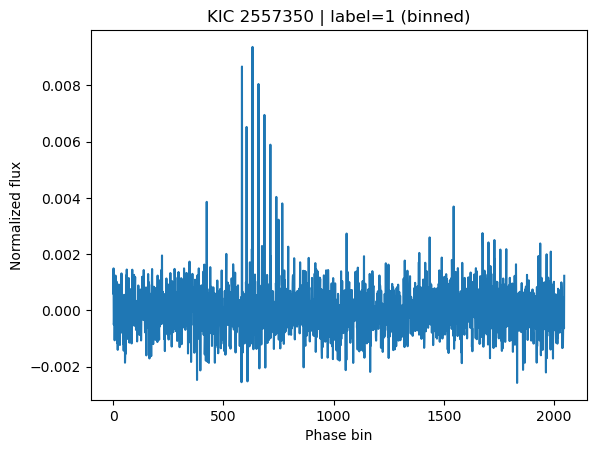

In [20]:
idx = np.where(y == 1)[0][0]

plt.plot(X[idx,:,0])
plt.title(f"KIC {kepids[idx]} | label=1 (binned)")
plt.xlabel("Phase bin")
plt.ylabel("Normalized flux")
plt.show()

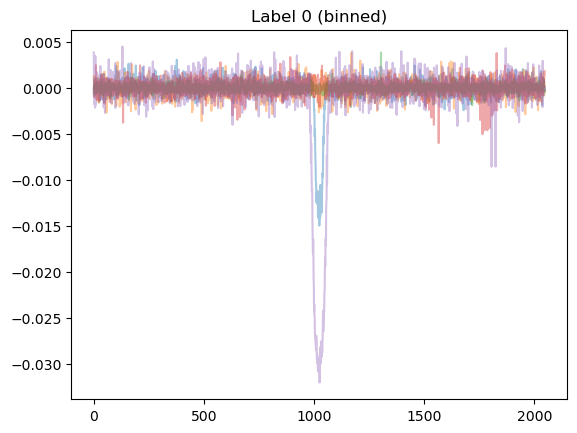

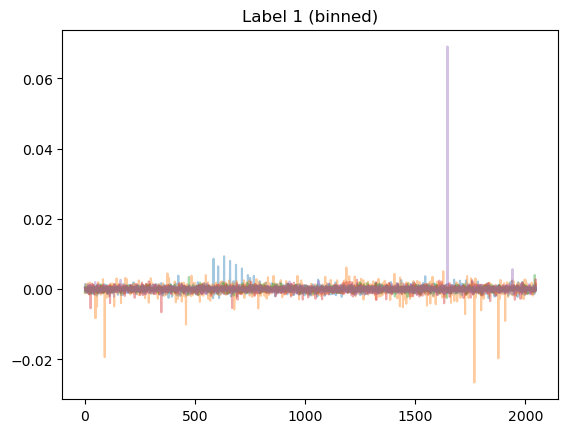

In [21]:
for lbl in [0, 1]:
    idxs = np.where(y == lbl)[0][:5]
    for i in idxs:
        plt.plot(X[i,:,0], alpha=0.4)
    plt.title(f"Label {lbl} (binned)")
    plt.show()


In [28]:
pipe = KOIPipeline()

fold_stats, all_probs = pipe.train_cnn_groupkfold(
    X_lc=X,
    y=y,
    groups=kepids,
    n_splits=5,
    epochs=40,
    batch_size=16,   # 16 is good for N=115
)



===== GroupKFold 1/5 =====
[balance] Train: {0: 61, 1: 31}
[balance] Val:   {0: 17, 1: 6}
[cnn] class_weight: {0: 0.7540983606557377, 1: 1.4838709677419355}
Epoch 1/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.3478 - auc: 0.4918 - loss: 0.6933 - precision: 0.3067 - recall: 0.7419 - val_accuracy: 0.2609 - val_auc: 0.5000 - val_loss: 0.6940 - val_precision: 0.2609 - val_recall: 1.0000
Epoch 2/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3696 - auc: 0.5000 - loss: 0.6934 - precision: 0.3483 - recall: 1.0000 - val_accuracy: 0.2609 - val_auc: 0.5000 - val_loss: 0.6944 - val_precision: 0.2609 - val_recall: 1.0000
Epoch 3/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3587 - auc: 0.5000 - loss: 0.6932 - precision: 0.3333 - recall: 0.9032 - val_accuracy: 0.2609 - val_auc: 0.5000 - val_loss: 0.6940 - val_precision: 0.2609 - val_recall: 1.0000
Epoch 4/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3913 - auc: 0.4918 - loss: 0.6932 - precision: 0.3377 - recal

**Analysis:** Using phase-folded, binned Kepler light curves alone, a 1D CNN achieves modest discrimination (ROC-AUC ≈ 0.6), indicating that morphology-only vetting is insufficient for low-SNR M-dwarf planets without auxiliary features.

### Visual results:

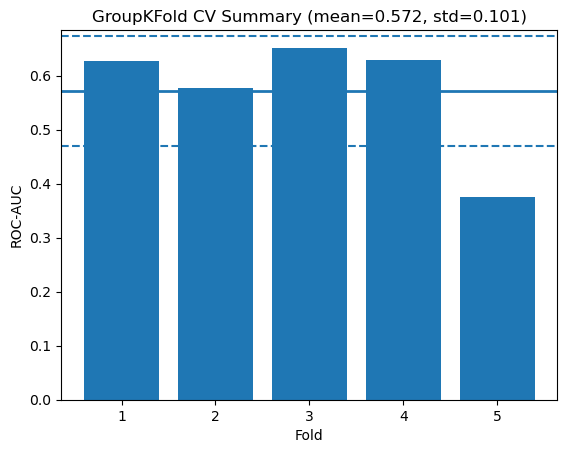

In [29]:
aucs = np.array([d["auc"] for d in fold_stats], dtype=float)
folds = np.arange(1, len(aucs) + 1)

mean_auc = np.nanmean(aucs)
std_auc  = np.nanstd(aucs)

plt.figure()
plt.bar(folds, aucs)
plt.axhline(mean_auc, linewidth=2)
plt.axhline(mean_auc + std_auc, linestyle="--", linewidth=1.5)
plt.axhline(mean_auc - std_auc, linestyle="--", linewidth=1.5)
plt.xlabel("Fold")
plt.ylabel("ROC-AUC")
plt.title(f"GroupKFold CV Summary (mean={mean_auc:.3f}, std={std_auc:.3f})")
plt.show()


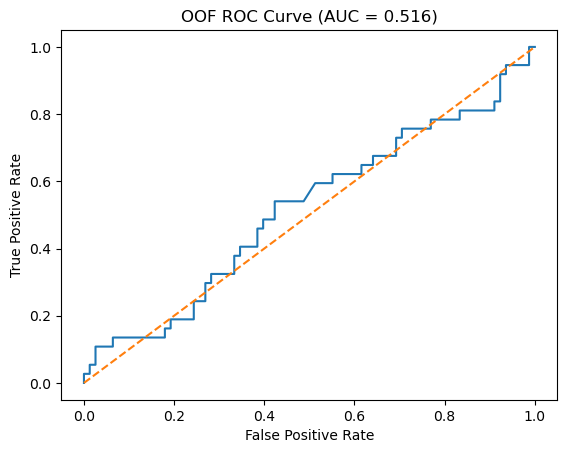

In [30]:
from sklearn.metrics import roc_curve, roc_auc_score

mask = ~np.isnan(all_probs)
y_oof = y[mask]
p_oof = all_probs[mask]

fpr, tpr, _ = roc_curve(y_oof, p_oof)
auc_oof = roc_auc_score(y_oof, p_oof)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"OOF ROC Curve (AUC = {auc_oof:.3f})")
plt.show()


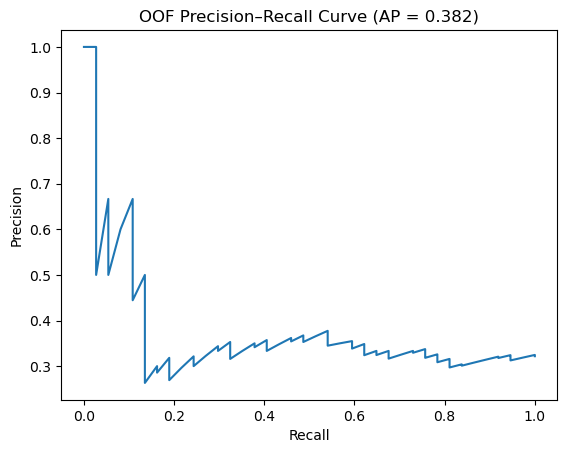

In [31]:
from sklearn.metrics import precision_recall_curve, average_precision_score

prec, rec, _ = precision_recall_curve(y_oof, p_oof)
ap = average_precision_score(y_oof, p_oof)

plt.figure()
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"OOF Precision–Recall Curve (AP = {ap:.3f})")
plt.show()


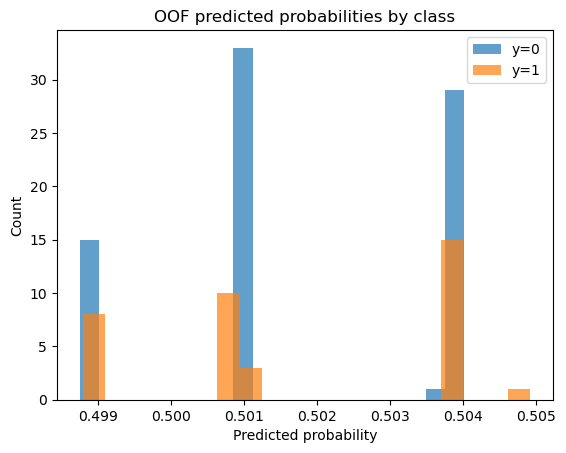

In [32]:
plt.figure()
plt.hist(p_oof[y_oof == 0], bins=20, alpha=0.7, label="y=0")
plt.hist(p_oof[y_oof == 1], bins=20, alpha=0.7, label="y=1")
plt.xlabel("Predicted probability")
plt.ylabel("Count")
plt.title("OOF predicted probabilities by class")
plt.legend()
plt.show()
